In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mu = 4
sigma2 = 3
N = 10000

np.random.seed(42)

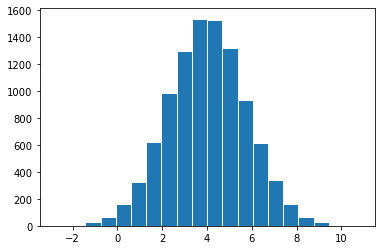

In [3]:
norm = stats.norm(loc=mu, scale=np.sqrt(sigma2))

data = norm.rvs(size=N)
plt.hist(data, bins=20, edgecolor='w');

In [4]:
fitPars = stats.norm.fit(data)
print(fitPars)

(3.996300368281764, 1.7379609219519137)


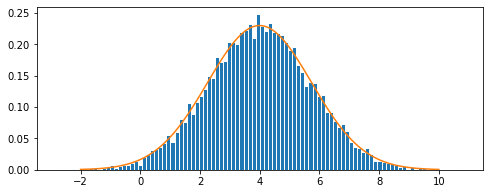

In [5]:
fittedNorm = stats.norm(loc=fitPars[0], scale=fitPars[1])

x = np.linspace(-2, 10, N)
y = fittedNorm.pdf(x) # Calculate the corresponding PDF

plt.figure(figsize=(8,3))
plt.hist(data, bins=100, density=True, edgecolor='w')
plt.plot(x, y)
plt.show()

# Lab 1
* Estimators
    + Point Estimators
    * Confidence Intervals
* Hypothesis Testing


## Estimators
Let $X_1, X_2, \dots ,X_N$, $N=1000$, independent r.v. drawn from $N(\mu, 7.5)$. Consider the estimator $\hat{\mu} = \bar{X}=\sum_{i=1}^{N}{X_i}$.
1. Compute a point estimate of $\mu$
2. Compute a confidence interval for $\mu$ of level $1-\alpha$, with $\alpha=0.05$
3. Test the hypothesis $H_0:\mu=15$ against the two-sided alternative hypothesis $H_1:\mu\neq 15$ at level $95\%$
4. **BONUS**: Repeat the above procedure a number of times equal to $B=1000$, and check the distribution of the estimator $\bar{X}$
5. **BONUS**: Repeat point 4 with $X_i \sim Bin(30, 0.5)$

In [6]:
mu = 15
sigma2 = 7.5
N = 1000
np.random.seed(42)

# creating a frozen distribution:
norm = stats.norm(loc=mu, scale=np.sqrt(sigma2))
# sampling from the distribution:
data = norm.rvs(N)

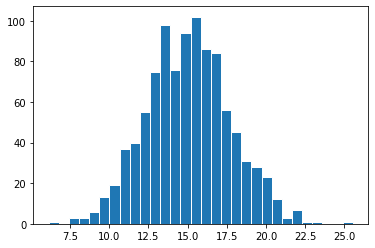

In [7]:
plt.hist(data, bins=30, ec='w')
plt.show()

1. Compute a point estimate for $\mu$

In [8]:
np.mean(data)

15.052943015284184

The same result can be obtained by applying the `fit` method:

In [13]:
mu_hat, var_hat = stats.norm.fit(data)
mu_hat

15.052943015284184

2. Compute a confidence interval for $\mu$

We know $\bar{X} \sim N(\mu, \sigma^2/N)$, so a confidence interval with $\alpha=0.05$ is given by $\bar{X} \pm z_{1-\alpha/2} \frac{\sigma}{\sqrt{N}}$

In [14]:
alpha = 0.05

conf_interval = stats.norm.interval(alpha, loc=mu_hat, scale=np.sqrt(sigma2))
conf_interval

(14.881213431344355, 15.224672599224013)

In [15]:
def draw_pdf(frozen_dist, figsize=(10, 5), eps=1e-4, interval=None):
    x = np.linspace(frozen_dist.ppf(eps), frozen_dist.ppf(1-eps), 1000)
    # Calculate the corresponding PDF
    y = frozen_dist.pdf(x) 
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(x, y)
    if interval:
        lowl, uppl = interval
        ax.vlines(lowl, ymin=0, ymax=frozen_dist.pdf(lowl))
        ax.vlines(uppl, ymin=0, ymax=frozen_dist.pdf(uppl))
        ax.fill_between(x, [0]*len(y), y, where=[(i > lowl) & (i < uppl) for i in x], alpha=0.3)
    return ax

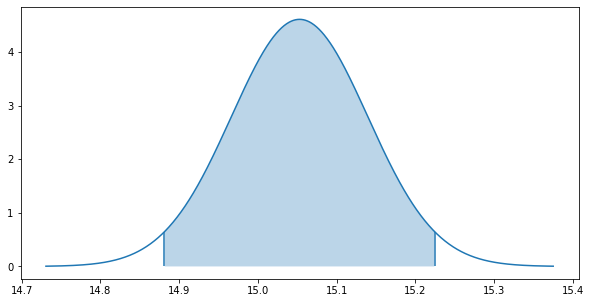

In [16]:
sample_mean_dist = stats.norm(loc=mu_hat, scale=np.sqrt(sigma2/N))

ax = draw_pdf(frozen_dist=sample_mean_dist, interval=conf_interval)

We can obtain the same result by applying directly the formula:

In [17]:
interval_width = stats.norm.ppf(1-alpha/2) * np.sqrt(sigma2/N)
np.round(mu_hat - interval_width, 2), np.round(mu_hat + interval_width, 2)

(14.88, 15.22)

3. Test the hypothesis
$$
\left\{
    \begin{array}\\
        H_0:\mu=15 \\
        H_1:\mu\neq 15
    \end{array}
\right.
$$

That's a **two-sided composite** alternative hypothesis, so we reject $H_0$ for both big and small number of the test statistic $Z = \frac{\bar{X}-\mu}{\sigma/\sqrt{N}}$

In [18]:
mu0 = 15

z_oss = (mu_hat - mu0) / np.sqrt(sigma2 / (N-1))
p_value = (1-stats.norm.cdf(z_oss))*2
print(f"{z_oss=}, two-sided {p_value=}")

z_oss=0.6110275394245253, two-sided p_value=0.5411813486797858


In real world scenarios the variance is unknown and needs to be estimated with the sample variance $S^2 = \frac{1}{N}\sum_{i=1}^N (X_i-\bar{\mu})^2$.  
If we replace $\sigma^2$ with its estimate $S^2$, the statistic follow a Student-t distribution:  
$T = \frac{\bar{X}-\mu}{S/\sqrt{N}}\sim t_\nu$ with degrees of freedom $\nu=N-1$

In [16]:
t_oss = (mu_hat - mu0) / np.sqrt(np.var(data) / (N-1))
p_value = (1-stats.t.cdf(t_oss, df=N-1))*2
print(f"{t_oss=}, two-sided {p_value=}")

t_oss=0.6243089585093181, two-sided p_value=0.532567243662303


`scipy.stats` module provides automatic methods for the most common test procedures:

In [19]:
stats.ttest_1samp(data, popmean=mu0)

Ttest_1sampResult(statistic=0.6243089585093181, pvalue=0.5325672436623032)

4. **BONUS**: Repeat the above procedure a number of times equal to $B=1000$, and check the distribution of the estimator $\bar{X}$


For each repetition of the experiment (steps 1-3 above) we store the values of the sample mean, of the $p$-value, and the confidence intervals:

In [21]:
B = 10000
mu_hats = []
conf_intervals = []
p_values = []
for i in range(B):
    
    # Generate a random sample
    data = norm.rvs(N)
    
    # Compute point estimate
    mu_hat = np.mean(data)
    
    # Compute confidence interval
    interval_width = stats.norm.ppf(1-alpha/2) * np.sqrt(sigma2/N)
    conf_interval = mu_hat - interval_width, mu_hat + interval_width
    
    # Compute p-values
    z_oss = (mu_hat - mu0) / np.sqrt(sigma2 / (N-1))
    p_value = (1 - stats.norm.cdf(np.abs(z_oss)))*2
    
    # Save quantities 
    mu_hats.append(mu_hat)
    conf_intervals.append(conf_interval)
    p_values.append(p_value)

We now plot the sampling distribution of the mean, and compare it with the theoretical value:

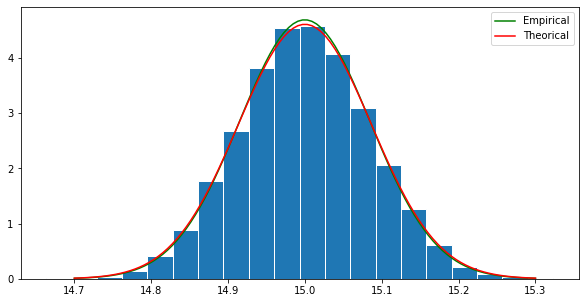

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(mu_hats, ec='w', bins=20, density=True)
x = np.linspace(14.7, 15.3, num=100)
y_emp = stats.norm.pdf(x, loc=np.mean(mu_hats), scale=np.std(mu_hats))
y_theo = stats.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2/N))
ax.plot(x, y_emp, label='Empirical', color='green')
ax.plot(x, y_theo, label='Theorical', color='red')
ax.legend();

Intervals of confidence level $95\%$: we expect those intervals to contain the true value of $\mu$ in $95\%$ of the cases.

In [22]:
counts = 0
for low, upp in conf_intervals:
    if (low < mu) & (mu < upp):
        counts+=1
counts/B

0.9473

<span style="color:red">NOTE CARLO</span>: <br>
io rifarei con B = 50 e plotterei cosi: 
https://statisticsbyjim.com/hypothesis-testing/confidence-interval/

Hypothesis testing with significativity level $95\%$: we expect those test to make type I error only in $5%$ of the cases.  
Remember: type I error is when we reject the null hypothesis when in reality it's correct

In [20]:
counts = 0
for p_val in p_values:
    if p_val < alpha:
        counts+=1
counts/B

0.0435

5. Repeat with $X\sim Bernoulli(p), p=0.5$

In [24]:
B = 10000
p = 0.5
bern = stats.bernoulli(p=p)
sigma2_bern = p * (1-p)


p_hats = []
conf_intervals = []
p_values = []
z_osss = []
for i in range(B):
    
    # Generate a random sample
    data = bern.rvs(N)
    
    # Compute point estimate
    p_hat = np.mean(data)
    
    # Compute confidence interval
    interval_width = stats.norm.ppf(1-alpha/2) * np.sqrt(sigma2_bern/N)
    conf_interval = (np.mean(data) - interval_width), (np.mean(data) + interval_width)
    
    # Compute p-values
    z_oss = (np.mean(data) - p) / np.sqrt(sigma2_bern / (N-1))
    p_value = (1 - stats.norm.cdf(np.abs(z_oss)))*2
    
    # Save quantities 
    p_hats.append(p_hat)
    conf_intervals.append(conf_interval)
    p_values.append(p_value)
    z_osss.append(z_oss)

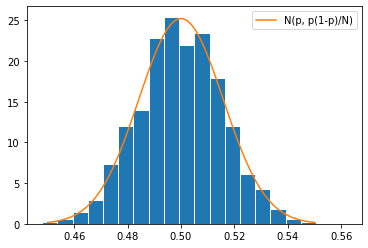

In [25]:
fig, ax = plt.subplots(1, 1)
ax.hist(p_hats, ec='w', bins=20, density=True)
x = np.linspace(0.45, 0.55, num=100)
y = stats.norm.pdf(x, loc=0.5, scale=np.sqrt(0.25/N))
ax.plot(x, y, label='N(p, p(1-p)/N)')
ax.legend();

**Why does the distribution of $\hat{p}$ look normal?**

In [23]:
counts = 0
for low, upp in conf_intervals:
    if (low < p) & (p < upp):
        counts+=1
counts/B

0.9466

In [24]:
counts = 0
for p_val in p_values:
    if p_val < alpha:
        counts+=1
counts/B

0.0461

<span style="color:red">NOTE CARLO: inserire un paio di esempi concreti di test delle ipotesi sulla media, utilizzando t-distribution. E.g. esercizio 9.7 pag 381 libro statistica per economisti</span>


## Chi-squared tests
### One-way Chi-Squared test
Assume you have a frequency table, and you want to test if the frequencies are random or if they follow some pattern. <br>

**Example** <br>
You've sold $N=33$ shirts of different colors, and from the sales data you want to understand if clients prefers some color over the others. You collect your data and have this frequency table:

| White      | Black | Blue | Green | Cyan | Lime | 
| ----------- | ----------- |----------- |----------- |----------- |----------- |
| 10      | 6 | 5 | 4|5|3|

It seems like people do have a preference for white shirts. But is it _statistically significant_?

One may expect that, on $N=33$ shirts of 6 colors, the mean number of shirts sold for each color would be 33/6 = 5.5.
What's the likelihood that this distribution came up by chance?

In [25]:
data = [10, 6, 5, 4, 5, 3]
V, p = stats.chisquare(data) 
print(p)

0.37313038594870584


<span style="color:red">NOTE CARLO: <br>
* bisogna stabilire a monte il livello di confidenza: il criterio va stabilito a monte!!!
* traiamo le conseguenze
</span>

# Two-way Chi-Squared test

<span style="color:red">NOTE CARLO: introdurre problema</span>

|| Male      | Female | Total |
|---| ----------- | ----------- | ------|
|Blonde| 84      | 102 | 186|
|Brunette| 161      | 119 | 280
|Total| 245 |221|466|

Is the color of hair related to the gender?  

$H_0$: variables are independent  
$H_1$: variables are not independent (meaning they're related)

The test statistic compares the observed frequencies with the expected ones, computed under the null hypothesis of independence, and follow a $\chi^2$ (*chi-squared*) distribution


In [26]:
data = np.array([[84,102], [161, 119]])
V, p, dof, expected = stats.chi2_contingency(data) 
print(p)

0.011817173153497198


### Normality test
Many analysis rely on the assumption of normality of the data. How can we test this assumption?  

$H_0$: data are normally distributed  
$H_1$: data are not normally distributed  

There are mainly two types of tests for normality:
1. "best fit": we fit a normal distribution (i.e. we compute mean and variance) on our data and ask ourself: is the expected distribution enough different from the fitted one to reject the hypothesis of normality?
2. tests based on descriptive statistics: we compute additional statistics on the empirical data, like indices of asymmetry (_skewness_) and heavy tails (_kurtosis_) and test these indices against the ones expected under normality assumption

The [Shapiro-Wilk](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) test combines a skewness and kurtosis test to produce a single, global “omnibus” statistic

In [27]:
np.random.seed(42)
data = stats.norm.rvs(size=100, loc=0, scale=1)
stats.shapiro(data)

ShapiroResult(statistic=0.9898834228515625, pvalue=0.6551706790924072)

In [28]:
data = stats.expon.rvs(size=100)
stats.shapiro(data)

ShapiroResult(statistic=0.8405630588531494, pvalue=5.396142643832036e-09)

## Data Drift

## A/B Testing